# 数据集准备

## 函数库

In [1]:
import plotly.express as px
import pandas as pd
import numpy as np

start='2023-12-01'
end='2024-11-30'
def Interplolate(df,time,order=2):
    df.loc[:,time]=pd.to_datetime(df[time])
    df.set_index(time,inplace=True)
    date_range = pd.date_range(start=start, end=end, freq='D')
    df = df[start:end].reindex(date_range)
    if np.isnan(df.iloc[0].item()):
        df.iloc[0]=df.mean().item()
    return df,df.interpolate(method='spline',order=order)

def BfAfInterplolate(df,df_filled):
    fig = px.line(x=df.index, y=df[df.columns[0]], line_shape='linear', title="Yield over Time")

    fig.add_scatter(x=df_filled.index, y=df_filled[df_filled.columns[0]], mode='lines', name="Interpolated Data", line=dict(color='red'))
    var=np.var(df_filled.to_numpy())
    mean=np.mean(df_filled.to_numpy())
    fig.update_traces(connectgaps=False)
    fig.update_layout(
        title="Yield over Time",
        xaxis_title="Date",
        yaxis_title="Yield(%)",
        legend_title="Data",
        legend=dict(
            title="Legend",
            x=1,
            y=1
        )
    )
   
    fig.add_annotation(
        x=df_filled.index[len(df_filled)//2],  # 放置注释的x位置
        y=max(df_filled[df_filled.columns[0]]),  # 放置注释的y位置
        text=f"Variance: {var:.4f}Mean: {mean:.4f}",  # 方差值，保留四位小数
        showarrow=False,  # 不显示箭头
        font=dict(size=12, color='black'),  # 设置字体大小和颜色
        bgcolor='white'  # 背景颜色
    )
 
    fig.show()

def CalYield(Clsprc):
    e=Clsprc.to_numpy()
    e_filled = np.zeros(e.shape[0] + 1) 
    e_filled[1:]=e
    e_filled[0]=2*e[0]-e[1]
    Yield=np.log(e_filled[1:]/e_filled[:-1])*100
    return Yield
    
def StkProcessing(df,time,code,columns):
    df=df[df['Filling']==0]
    df_dict={}
    for column in columns:
        col_df = df[df[code].notnull()][[time,code, column]]
        col_df = col_df.pivot(index=time, columns=code, values=column)
        df_dict[column] = col_df

    return df_dict


## 数据清洗

In [2]:
import pandas as pd
import numpy as np
Market=pd.read_csv('data/TRD_Cndalym.csv')
Amarket=Market[Market['Markettype']==5]
Amarket.loc[:,'Cdretmdos'] = Amarket['Cdretmdos'] * 100
marketflow=Amarket[['Trddt','Cdretmdos']]

lowrisk=pd.read_csv('data/BND_TreasYield.csv')
lowrisk=lowrisk[lowrisk['Cvtype']==2]
lowrisk_1y=lowrisk[lowrisk['Yeartomatu']==1][['Trddt','Yield']]
lowrisk_1y.loc[:,'Yield']=lowrisk_1y['Yield'].astype(np.float64)/365
lowrisk_1y,lowrisk_1y_filled=Interplolate(lowrisk_1y,'Trddt')

marketflow,marketflow_filled=Interplolate(marketflow,'Trddt',1)
filled_datalist=[marketflow_filled,lowrisk_1y_filled]
datalist=[marketflow,lowrisk_1y]



## 数据集划分

In [3]:
# #spilt
# def split(datalist, a=0.8):
#     train_datas = []
#     test_datas = []
    
#     for df in datalist:
#         # 获取数据的分割点
#         train_size = int(len(df) * a)  # 计算训练集的大小
        
#         # 切割数据集
#         train_data = df.iloc[:train_size]  # 前 a% 的数据作为训练集
#         test_data = df.iloc[train_size:]  # 剩余的数据作为测试集
        
#         # 添加到对应的列表
#         train_datas.append(train_data)
#         test_datas.append(test_data)
    
#     return train_datas, test_datas
# train_datas,test_datas=split(filled_datalist)
# org_train,org_test=split(datalist)


## 收益率曲线展示

In [4]:
# for df,filled_df,test_df,filled_test_df in zip(org_train,train_datas,org_test,test_datas):
#     BfAfInterplolate(df,filled_df)
#     BfAfInterplolate(test_df,filled_test_df)

# 收益率溢价评估

## CAPM

In [5]:
# stk_index=np.arange(len(train_datas))[2:]
# def CalBetas(datalist,market_index,stk_index):
#     betas=[]
#     for i in stk_index:
#         cov=np.cov(datalist[i].to_numpy().flatten(),datalist[market_index].to_numpy().flatten())
#         betai=cov[0,1]/cov[1,1]
#         betas.append(betai)
#     return betas

# def CalERi(datalist,betas,market_index,lowrisk_index,episilon=0):
#     m=np.array(datalist)[market_index].squeeze(1)
#     l=np.array(datalist)[lowrisk_index].squeeze(1)
#     delta=m-l
#     return np.array(betas).reshape(-1,1)@delta.reshape(1,-1)+l

# def GetCovMatrix(datalist,stk_index):
#     return np.cov(np.array(datalist)[stk_index].squeeze(2),rowvar=True)

# betas=CalBetas(train_datas,0,stk_index)
# ERi=CalERi(train_datas,betas,0,1)
# CovMatrix=GetCovMatrix(train_datas,stk_index)



## 资产组合优化

## numpy解析法

In [6]:
# def minimize_sigma(sigma,u,u_star):
#     '''np方法得到给定收益率期望下使得风险系数最小的权重向量解析解'''
#     one=np.zeros((u.shape[0],1))+1
#     inv_sigma=np.linalg.inv(sigma)
#     A=np.concatenate((one.T,u.T))
#     P1=one.T@inv_sigma@A.T
#     P2=u.T@inv_sigma@A.T
#     P=np.concatenate((P1,P2))
#     b=np.matrix([1,u_star]).reshape(2,1)
#     lambdas=np.linalg.solve(P,b)
#     return lambdas.T@A@inv_sigma

# u=ERi[:,100].reshape(ERi.shape[0],1)
# w=minimize_sigma(CovMatrix,u,1)

# U=w@u
# var=w@CovMatrix@w.T

# print(w)
# print(U/np.sqrt(var))

## cvxpy凸优化库二次规划

In [7]:
# import cvxpy as cp
# def cp_minimize_sigma(CovMatrix,u,ustar):
#     w=cp.Variable(u.shape[0])

#     objective=cp.Minimize(cp.quad_form(w,CovMatrix))

#     constrains=[cp.sum(w)==1,w>=0,w@u>=ustar]

#     problem=cp.Problem(objective,constrains)
#     problem.solve()
#     if problem.status not in ["infeasible", "unbounded"]:
#         return w.value,cp.quad_form(w,CovMatrix).value
#     else:
#         raise ValueError("minimize Optimization did not succeed. Status: " + problem.status)
# def cp_maximize_u(CovMatrix,u,sig):
#     w=cp.Variable(u.shape[0])

#     objective=cp.Maximize(w@u)

#     constrains=[cp.sum(w)==1,w>=0,cp.quad_form(w,CovMatrix)<=sig]

#     problem=cp.Problem(objective,constrains)
#     problem.solve()
#     if problem.status not in ["infeasible", "unbounded"]:
#         return w.value,cp.quad_form(w,CovMatrix).value
#     else:
#         raise ValueError("maximize Optimization did not succeed. Status: " + problem.status)
# ustar=0.08
# sig=1.2
# w1,s1=cp_maximize_u(CovMatrix,u,sig)
# w2,s2=cp_minimize_sigma(CovMatrix,u,ustar)

# print(w1@u/np.sqrt(s1),w1@u,s1)
# print(w2@u/np.sqrt(s2),w2@u,s2)


# 回测

In [8]:
from Models.Dataset import *

time='TradingDate'
code='Symbol'
start='2023-12-01'
end='2024-11-30'
load=True
backup=False
save_path='SavedDataset/SaveData.pth'

files = [f'data/TRD_FwardQuotation{i}.csv' for i in range(1, 7)]
name_dict={"Oprc":'OpenPrice',"Clprc":'ClosePrice',"Tnovr":'TurnoverRate1',"MV":'MarketValue',"CMV":'CirculatedMarketValue'}

datadict={"files":files,
          "time_field":time,"code_field":code,"start":start,
        "end":end,"load":load,"save_path":save_path,"name_dict":name_dict,"backup":backup}



In [9]:
import importlib
from Models import Strategy
importlib.reload(Strategy)
from Models.Strategy import *

save_strategy=True

startday='2023-12-01'
sig=1.5
backtesting = MyStrategy(datadict,startday,sig,save_strategy)



Stock_dict loaded from SavedDataset/SaveData.pth in 0.10411906242370605 seconds
Strategy initialized in 0.10411906242370605 seconds


2024-12-10 13:56:26,814 - INFO - Logging system initialized.
2024-12-10 13:56:33,961 - INFO - Day 0Changed Portfolio_value: 100000.0
2024-12-10 13:56:33,974 - INFO - Day 1Changed Portfolio_value: 103390.62400000003
2024-12-10 13:56:33,988 - INFO - Day 2 Portfolio_value: 103325.40500000003
2024-12-10 13:56:33,995 - INFO - Day 3 Portfolio_value: 103001.33300000003
2024-12-10 13:56:33,998 - INFO - Day 4Changed Portfolio_value: 103446.70800000004
2024-12-10 13:56:34,009 - INFO - Day 5 Portfolio_value: 102792.22500000003
2024-12-10 13:56:34,015 - INFO - Day 6 Portfolio_value: 102699.51800000004
2024-12-10 13:56:34,024 - INFO - Day 7 Portfolio_value: 102499.99100000004
2024-12-10 13:56:34,028 - INFO - Day 8 Portfolio_value: 102045.29100000003
2024-12-10 13:56:34,034 - INFO - Day 9 Portfolio_value: 100786.50200000004
2024-12-10 13:56:34,044 - INFO - Day 10 Portfolio_value: 99860.79000000004
2024-12-10 13:56:34,048 - INFO - Day 11 Portfolio_value: 99555.76800000004
2024-12-10 13:56:34,057 - IN

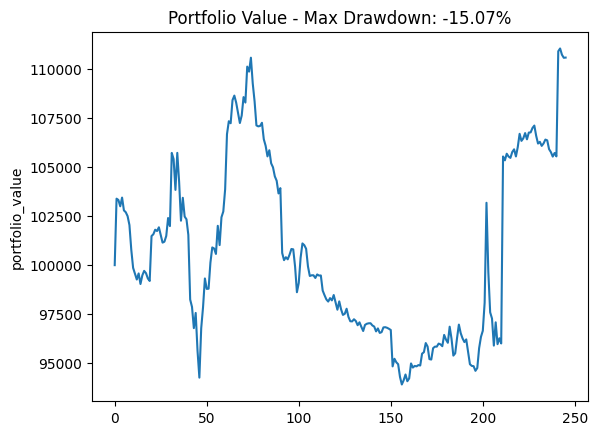

INFO:root:Backtest completed. Portfolio final value: 110585.98800000001


In [10]:
backtesting.run()
backtesting.show()